## Example for extracting datasets
>(to be used as predictors in a statistical mode)

This notebook exemplifies how to use automated functions to extract and store datasets given a polygon (or a set of polygons). The functions will extract all the datasets in the same dimension and geographical extent and parameters (i.e. all datapoints will have the same coordinates).

At the end the datasets are saved into a folder ready to be used into a statistical model.


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
from raster_api.models import raster_models as models
import utilities.data_extraction as de
from datapipelines import paper2 as p2


## Rebuilding polygons from obtained pseudio absences

In [3]:
from django.contrib.gis.geos import Point, Polygon
#coord = -99.76
#coord = 17.55
#xcoord = -98.219
#ycoord = 19.05
xcoord = -97.237
ycoord = 19.482
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,2,10)
polys = map(lambda r : p.buffer(r),radii)


In [4]:
## Run this if you only one to generate the predictor stack for a single polygon
#tiki = de.compilePredictorRasterStack(polys[0],200,200,models,as_dataframe=False)

In [5]:
from ecoregions.models import LandUseConabio

In [6]:
## Prepare the structure to retrieve the interested fields from the vector data.
# Please  include the NaNs definition.
from ecoregions.models import TerrEcoregions,InegiIV,LandUseConabio
vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],
           [InegiIV,['covid','name'],[np.nan,'NaN']],
           [LandUseConabio,['cov_id','tipos'],[np.nan,'NaN']]
          ]

#vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],[InegiIV,['covid','name'],[np.nan,'NaN']]]
#vectsel = [[TerrEcoregions,['wwf_mhtnum'],[np.nan]],[InegiIV,['covid'],[np.nan]]]

In [7]:
polys = [polys[9]]
%time datasets = map(lambda polygon : p2.compileRasterandVectorPredictors(polygon,100,100,models,vectsel),polys)

INFO Alligning stacked raster data to common origin...
INFO extracting info from: <class 'ecoregions.models.TerrEcoregions'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.InegiIV'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.LandUseConabio'> this can take some minutes


CPU times: user 33.8 s, sys: 2.12 s, total: 35.9 s
Wall time: 2min 55s


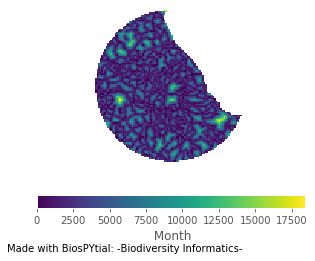

[None]

In [8]:
map(lambda r : r['rasters'][9].display_field(),datasets)

In [9]:
## Save it in Redis
import redis
import pickle
conn = redis.StrictRedis(host='redis',password='biospytial.')

In [10]:
tag = 'p-100x100-puebla-poly9'
#tag = 'p-100x100-puebla-poly4'
#tag = 'p-100x100-puebla-poly2'
d = datasets[0]['df']

In [11]:
conn.set(tag,pickle.dumps(d))

True

In [ ]:
Check the meantemp is fine

## Let´s save it for the posterity
We need to encode the name into utf8, because.... python 2 !! 

In [14]:
dataframes = map(lambda d : d['df'],datasets)
for i,d in enumerate(dataframes):
    cad = '/outputs/presence_only_models/predictors/dataset100x100-puebla-p2/%s-pred.csv'%i
    print(cad)
    d.to_csv(cad,encoding='utf8')

/outputs/presence_only_models/predictors/dataset100x100-puebla-p2/0-pred.csv
